# Aula 6 - Regressão Logística

In [3]:
# -*- coding: utf8 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [4]:
from numpy.testing import assert_almost_equal
from numpy.testing import assert_equal
from numpy.testing import assert_array_almost_equal
from numpy.testing import assert_array_equal

## Breast Cancer Dataset

Esse dataset contém dados de pacientes com tumores de mama, você tentará prever se um tumor é maligno ou benigno de acordo com a espessura do tumor. No gráfico abaixo você pode visualizar os tipos de tumores (1 = maligno, 0 = benigno) por categoria de espessura.

|Index | Attribute | Domain |
|----|----|----|
0|Sample code number | id number
1|Clump Thickness | 1 - 10
2|Uniformity of Cell Size | 1 - 10
3|Uniformity of Cell Shape | 1 - 10
4|Marginal Adhesion | 1 - 10
5|Single Epithelial Cell Size | 1 - 10
6|Bare Nuclei | 1 - 10
7|Bland Chromatin | 1 - 10
8|Normal Nucleoli | 1 - 10
9|Mitoses | 1 - 10
10|Class | (2 for benign, 4 for malignant)

### Pré-processamento dos dados

In [5]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'\
                'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                header=None)
# o nosso dataset contém strings `?` no lugar de dados faltantes
# vamos substituir esses valores para não termos problemas na execução
# das abordagens numéricas
#df.replace('?', np.NaN, inplace=True)

In [6]:
df.replace('?', np.NaN, inplace=True)
scaled_df = df.iloc[:, 1:-1].copy()
scaled_df = scaled_df.drop(columns=6)
scaled_df = (scaled_df - scaled_df.mean())/scaled_df.std()

In [7]:
X = scaled_df
X = np.nan_to_num(X)
y = df.iloc[:, -1]
y = y.values
y[y==2] = 0
y[y==4] = 1

Enfim, vamos obter os conjuntos de treino e teste para os algoritmos que vamos implementar:

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
                                                    random_state=32)

## Regressão Logística

Como discutido na aula, a regressão logística baseia-se na função sigmoide:

$$f_\theta(x) = \frac{1}{1+e^{-\theta x_i}}$$

À medida que sua entrada se torna grande e positiva, $f(x)$ se aproxima e se aproxima de 1. À medida que sua entrada se torna grande e negativa, $f(x)$ se aproxima e se aproxima de 0.

### Aquecimento 1

Você consegue implementar a função `sigmoid` abaixo?

In [9]:
def sigmoid(x, theta):
    return 1/(1 + np.exp(-np.dot(x, theta)))

Além disso, $f(x)$ tem a propriedade conveniente que sua derivada é dada por:

$$f_\theta'(x) = \frac{e^{-x}}{(1+e^{-\theta x_i})^2} = f(x)(1-f(x))$$


Vamos testar a função implementada:

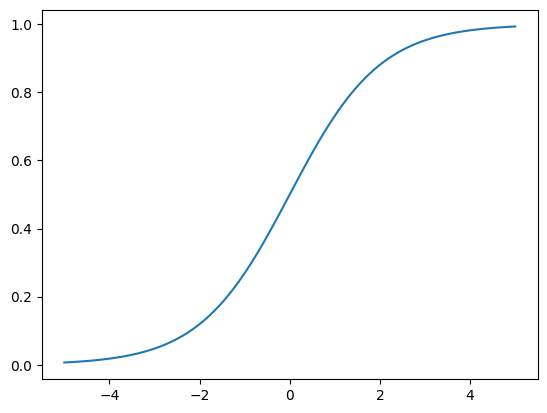

In [10]:
x = np.linspace(-5,5,100)
theta = 1
y = sigmoid(x, theta)
plt.plot(x, y)

### Aquecimento 2

Você consegue implementar a função `sigmoid_prime` abaixo?

In [11]:
def sigmoid_prime(x, theta):
    return sigmoid(x, theta)*(1 - sigmoid(x, theta))

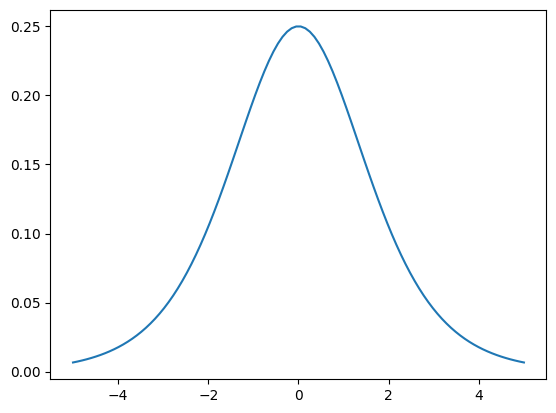

In [12]:
plt.plot(x, sigmoid_prime(x, theta))

Vamos usar a função sigmoide para ajustar um modelo:

$$y_i = f(x_i\theta) + \epsilon_i$$

onde $f$ é a função logística (`sigmoid`).

Note também que $x_i\theta$, para $j$ variáveis independentes, nada mais é que o modelo linear visto nas aulas anteriores, que é calculado e dado como entrada para a função logística:

$$x_i\theta = \theta_0 + \theta_1 x_1 + \cdots + \theta_j x_j$$

Ao contrário do que acontece no caso da Regressão Linear, precisamos calcular diretamente a função de verossimilhança e seu gradiente. Porém, vimos que é mais simples maximizar o logaritmo da verossimilhança (*log likelihood*):

$$\log ll_{\theta}(y_i~|~x_i) = y_i \log f(x_i\theta) + (1-y_i) \log (1-f(x_i\theta))$$


### Cross Entropy

Ao invés de trabalhar na verossimilhança, vamos invertê-la e utilizar o *cross entropy* para a regressão logística.

$$L(\theta) = -n^{-1}\sum_i \big((1-y_i)\log_2(1-f_{\theta}(x_i)) + y_i\log_2(f_{\theta}(x_i))\big)$$

A equação acima é a cross-entropy média por observação.

#### Aquecimento 3

Você consegue implementar a cross-entropy média na função `cross_entropy_mean` abaixo?

Dica: você pode utilizar a função `np.clip(vetor, limite_inferior, limite_superior)` para evitar imprecisões numéricas quando calcular logarítimos ou realizar divisões.

Por exemplo, o exemplo abaixo limita os valores do `vetor_exemplo` entre 0.0001 e 0.9999. Ou seja, se o vetor tiver um valor 1.01 por erro numérico, corrigimos para 0.9999.

```
vetor = [0.00, 0.01, 1.02]
novo_vetor = np.clip(vetor, 0.00001, 0.99999)
# novo_vetor: [0.0001, 0.01, 0.9999]
```

In [13]:
def cross_entropy_mean(X, y, theta):
    yp = y > 0.5
    logit = sigmoid(X, theta)
    logit = np.clip(logit, 0.00001, 0.99999)
    return -(yp * np.log(logit) + (1 - yp) * np.log(1 - logit)).mean()

### Derivada de $L(\theta)$

A derivada de $L(\theta)$ tem uma forma similar ao da regressão linear. Veja a derivação nos [slides](https://docs.google.com/presentation/d/1yGPETPe8o7PPOP6_CF38LHr3vpxgTEnF5LjP-1pkGIc/edit?usp=sharing). Partindo da derivada $f_\theta'(x)$, definida acima, chegamos em:

> Indented block



$$
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)f'_{\theta}(x_i)}{1- f_{\theta}(x_i)} + \frac{y_if'_{\theta}(x_i) }{f_{\theta}(x_i)}\big)
$$

Simplificando:

$$
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)f'_{\theta}(x_i)}{1- f_{\theta}(x_i)} + \frac{y_if'_{\theta}(x_i) }{f_{\theta}(x_i)}\big) \\
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)}{1- f_{\theta}(x_i)} + \frac{y_i}{f_{\theta}(x_i)}\big)f_{\theta}(x_i)(1-f_{\theta}(x_i)) \\
L'(\theta) = -n^{-1}\sum_i \big(-\frac{(1-y_i)}{1- f_{\theta}(x_i)} + \frac{y_i}{f_{\theta}(x_i)}\big)f_{\theta}(x_i)(1-f_{\theta}(x_i)) \\
L'(\theta) = -n^{-1}\sum_i (y_i - f_{\theta}(x_i)) x_i
$$

#### Aquecimento 4

Você consegue escrever a forma vetorizada de $L'(\theta)$ na função `derivadas` abaixo?

In [14]:
def derivadas():
    
    

## Gradiente Descendente

Na Aula 5, utilizamos o gradiente descendente no contexto da Regressão Linear. Agora, vamos aplicar o gradiente descendente para o caso da Regressão Logística. A ideia aqui é a mesma:

1. Escolha um valor inicial do vetor (e.g., θ = [0.2, 1, -2, 5])
2. Escolha uma taxa de aprendizado (e.g., λ = 0.01)
3. Repita:
  1. Compute a derivada da log-verossimilhança (log likelihood) ll'(θ)
  2. Atualize $\theta$
4. Pare quando convergir



#### Exercício 1

Modifique a implementação de `gd` para o caso da regressão logística.

In [22]:
def gd(X, y, lambda_=0.01, tol=0.0000001, max_iter=10000):
    theta = np.ones(X.shape[1])
    # print('Iter {}; theta = '.format(0), theta)
    old_err = np.inf
    m = y.size
    i = 0
    while True:
        # Computar as derivadas. Modifique a linha 8 abaixo
        h = sigmoid(X, theta)
        grad = np.dot(X.T, (h - y)) / m + (lambda_/m) * theta
        # Atualizar
        theta_novo = theta - lambda_ * grad
        # Parar quando o erro convergir.
        # Modifique a linha 13 abaixo.
        err = cross_entropy_mean(X, y, theta_novo)
        if np.abs(old_err - err) <= tol:
            break
        theta = theta_novo
        old_err = err
        # print('Iter {}; theta = {}; cross_e = {}'.format(i+1, theta, err))
        i += 1
        if i == max_iter:
            break
    return theta

Testando:

In [23]:
theta = gd(X_train, y_train)

r2_train = cross_entropy_mean(X_train, y_train, theta)
r2_test = cross_entropy_mean(X_test, y_test, theta)
assert_equal(np.round(r2_train,2), np.round(0.08605687702630486,2))
assert_equal(np.round(r2_test,2), np.round(0.18899648326443957,2))

## Gradiente Descendente Estocástico

Relembrando a Aula 3:
> Muitas vezes usaremos o gradiente descendente para escolher os parâmetros de um modelo de maneira a minimizar alguma noção de erro. Usando a abordagem em lote anterior, cada etapa do método exige que façamos uma previsão e calculemos o gradiente para todo o conjunto de dados, o que faz com que cada etapa demore muito. <br>
> <br> Geralmente, essas funções de erro são *aditivas*, o que significa que o erro preditivo em todo o conjunto de dados é simplesmente a soma dos erros preditivos para cada ponto de dados. <br>
> <br> Quando este é o caso, podemos, em vez disso, aplicar uma técnica chamada gradiente descendente estocástico (ou *stochastic gradient descent*), que calcula o gradiente (e dá um passo) para apenas um ponto por vez. Ele passa sobre os dados repetidamente até atingir um ponto de parada.





### Exercício 2

Modifique a implementação de `sgd` para o caso da regressão logística.

In [28]:
def sgd(X, y, lambda_=0.001, tol=0.01, max_iter=10000):
    theta = np.ones(X.shape[1])
    # theta = theta.copy()
    # print('Iter {}; alpha, beta = '.format(0), theta)
    old_err_sq = np.inf
    for i in range(max_iter):
        # Escolhe ponto aleatório
        r = np.random.randint(len(y))
        X_r, y_r = X[r], y[r]
        X_r = X_r.reshape(1, len(X_r)) # transforma o vetor linha em matriz
                
        # Deriva e atualiza
        # Modifique a linha 14 abaixo.
        h = sigmoid(X_r, theta)
        grad = np.dot(X_r.T, (h - y_r)) + (lambda_/len(y)) * theta
        theta_novo = theta - lambda_ * grad
        
        # Calcula o erro
        # Modifique a linha 19 abaixo.
        err_sq = cross_entropy_mean(X, y, theta_novo)
        
        theta = theta_novo
        if err_sq < tol:
            break
        
        #print('Iter {}; alpha, beta = '.format(i+1), theta)

    return theta

Testando:

In [29]:
theta = sgd(X_train, y_train)

r2_train = cross_entropy_mean(X_train, y_train, theta)
r2_test = cross_entropy_mean(X_test, y_test, theta)
assert_equal(np.round(r2_train,2), np.round(0.09296116832663982,2))
assert_equal(np.round(r2_test,2), np.round(0.19610717861042887,2))

## sklearn: LogisticRegressionCV (somente didatico)

Por último, temos um exemplo de regressão logística com regularização L2 utilizando a biblioteca sklearn.

O exemplo abaixo usa a versão com validação cruzada, a função *LogisticRegressionCV*, cuja documentação você encontra [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV). A maior diferença desta implementação para as abordagens que estudamos na Aula 6 é que a LogisticRegressionCV usa, por padrão, um método da família quasi-Newton invés do gradiente descendente, o [Limited-memory BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS). 

Como grande parte das funções implementadas no sklearn, a LogisticRegressionCV possui vários parâmetros configuráveis, cuja melhor configuração vai depender do problema com o qual se está trabalhando. Dê uma olhada na documentação e tente brincar com as várias combinações de parâmetros!

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(penalty='l2', cv=3).fit(X_train, y_train)
predictions = clf.predict(X_test)
print(clf.predict_proba(X_test).shape)
# No caso deste modelo, o score padrão computado é a acurácia (0, 1).
# Podemos escolher outras funções já implementadas ou 
# passar a nossa própria métrica como parâmetro no momento da construção
# do regressor -> clf = LogisticRegressionCV(..., scoring=metrica_de_interesse)
# métricas implementadas:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
print(clf.score(X_test, y_test))

In [ ]:
clf.coef_

In [ ]:
print("Cross-entropy em teste = ", cross_entropy_mean(X_test, y_test, clf.coef_[0]))